# Segmenting with Mask R-CNN

This notebook covers how to run simple inference using Mask R-CNN and how to display the qualitative results.

In [1]:
# Imports
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io
import glob
import albumentations as A


# Root directory of the project
ROOT_DIR = os.path.abspath(os.getcwd())

# Import Mask RCNN Library
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn import stats_utils

# Import Base class
import Monuseg

%matplotlib inline 
%load_ext autoreload
%autoreload 2

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

MONUSEG_DIR = os.path.join(ROOT_DIR, "datasets", "monuseg")
config = Monuseg.MonusegInferenceConfig()


c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' 

## Load Data

In [2]:
# Load dataset - Val, as seen in Dataset Notebook
subset = "val"
dataset_dir = os.path.join(MONUSEG_DIR, subset)
image_dir = os.path.join(dataset_dir, "tissue_images")
image_ids = os.listdir(image_dir)
print("Found {} images in {}".format(len(image_ids), image_dir))


dataset = Monuseg.MonusegDataset("UNET")
dataset.add_class(source = "Monuseg", class_id =  1, class_name = "nucleus")

# Fill with the samples
i = 0
for _id in image_ids:
    name,_ = os.path.splitext(_id)
    if i <= len(image_ids):
        dataset.add_image(source = "Monuseg",
                                image_id = name,
                                path = os.path.join(image_dir, _id))
    i+=1    

    
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Found 14 images in C:\Users\User\GitHub\Improved Mask R-CNN\datasets\monuseg\val\tissue_images
Image Count: 14
Class Count: 2
  0. BG                                                
  1. nucleus                                           


## Load Model

In [3]:
DEVICE = "/gpu:0" # alt: "/cpu:0"
TEST_MODE = "inference" 

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
# PATH:    
weights_path = os.path.join(ROOT_DIR, "example_model.h5")
print("Loading weights ", weights_path)

# Load Model weights
model.load_weights(weights_path, by_name=True)









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  C:\Users\User\GitHub\Improved Mask R-CNN\example_model.h5


## Run detection

Detect works on a list of images, returns a list of dicts with rois (bounding boxes), binary instance masks (HxWxN), class ids, and classification scores

Keywords: "rois", "masks", "class_ids", "scores"

In [4]:
#source = "TCGA-HT-8564-01Z-00-DX1"
#_id = dataset.image_from_source_map["Monuseg.{}".format(source)]
_id = 2
image = dataset.load_image(_id)
name = dataset.image_info[_id]["id"]


print("Running detection on {}...".format(name))
r = model.detect([image], verbose = 1)[0]
print("Done detecting...")
# Print results
print("Output Mask Shape: ", r["masks"].shape)
# Print AJI, PQ scores
gt_mask = dataset.load_mask(_id)[0]
print("GT Mask Shape: ", gt_mask.shape)
aji, pq = utils.calc_aji_pq(r["masks"], gt_mask)
print("AJI: {}, PQ: {}".format(aji, pq))

Running detection on TCGA-69-7764-01A-01-TS1...
Processing 1 images
image                    shape: (1000, 1000, 5)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 5)    min: -176.31887  max:  239.81833  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
Done detecting...
Output Mask Shape:  (1000, 1000, 515)
GT Mask Shape:  (1000, 1000, 441)
AJI: 0.6072168486868494, PQ: 0.5921192119518741


Results are saved in a dictionary containing: 
-    "rois" : bboxes, 
-    "masks" : HxWxN instance masks, 
-    "scores" : Mask R-CNN detection scores, 
-    "class_ids" : classification result 
  
Visualize: Takes RGB-image, results of detection and class names to display. We suppress a few things (masks, bboxes, scores) for better viewing

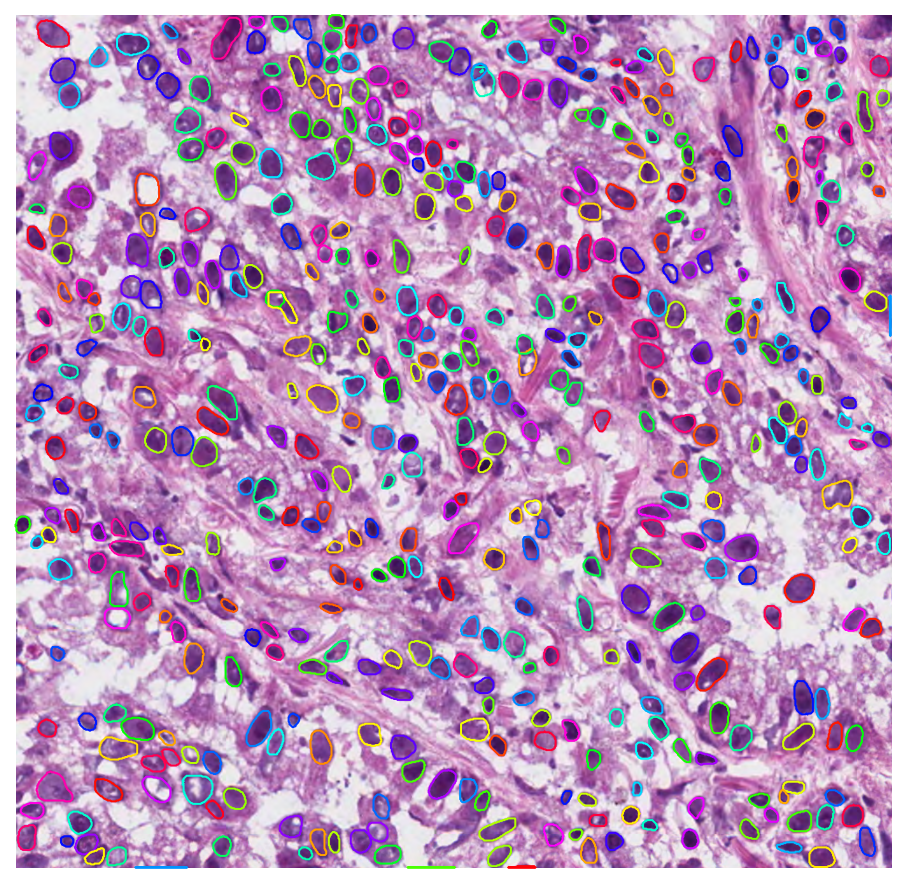

In [5]:
visualize.display_instances(image[:,:,0:3], r['rois'], r['masks'], r['class_ids'], 
                            ["BG", ""], r['scores'], use_captions=False, show_mask = False, show_bbox = False)

## Compare detections to GT

Here we use the internal load_image_gt function for speed \
This function loads the ground truth data used during model training. It applies image transformations (like crop or pad) defined in the config and returns an input image, its corresponding GT mask, class_ids, and bounding boxes


In [6]:
# Crop for better viewing
config.IMAGE_RESIZE_MODE = "crop"
_id = 1

image, _, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, _id, use_mini_mask=False)

name = dataset.image_info[_id]["id"]
print("Running detection on {}...".format(name))

r = model.detect([image], verbose = 1)[0]
print("Done detecting...")
# Print results
print("Output Mask Shape: ", r["masks"].shape)
print("GT Mask Shape: ", gt_mask.shape)


Running detection on TCGA-44-2665-01B-06-BS6...
Processing 1 images
image                    shape: (256, 256, 5)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 5)      min: -176.31887  max:  214.81833  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Done detecting...
Output Mask Shape:  (256, 256, 77)
GT Mask Shape:  (256, 256, 78)


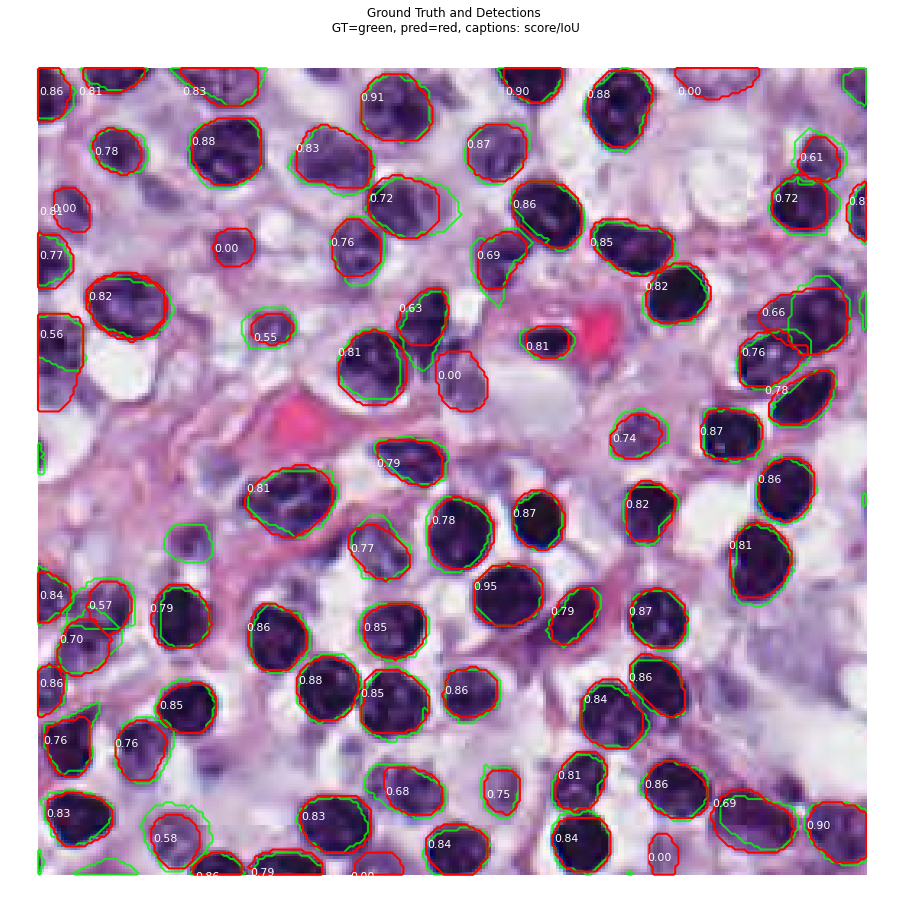

In [7]:
visualize.display_differences(
    image[:,:,0:3],
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names,
    show_box=False, show_mask=False, show_scores=True,
    iou_threshold=0.5, score_threshold=0.5)